In [146]:
import requests
import osmnx as ox
import networkx as nx
import geopandas as gpd
import numpy as np
import pandas as pd

                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((301997.266 -4082816.606, 302016.825 ...  -36.867678  -36.870725   

    bbox_east   bbox_west   place_id osm_type    osm_id        lat  \
0  174.779537  174.778569  118523389      way  48383821 -36.869262   

          lon                                       display_name    class  \
0  174.778972  Newmarket, Joseph Banks Terrace, Newmarket, Au...  railway   

      type  importance  
0  station    0.460255  


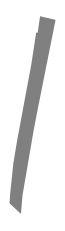

In [2]:
# Find Auckland location from osmx package
city = ox.geocode_to_gdf("NewMarket, Auckland, NZ")
city_proj = ox.project_gdf(city)
ax = city_proj.plot(fc="gray", ec="none")
_ = ax.axis("off")
print(city_proj)

In [150]:
gdf = ox.geometries.geometries_from_point((-36.8679152, 174.7774390),tags={'amenity':True,'shop':True},dist=100)
gdf.drop(['addr:housenumber', 'addr:street',
          'phone','website',
          'wheelchair','addr:city',
          'payment:coins','brand',
          'brand:wikidata',
          'brand:wikipedia',
          'cuisine',
          'operator','operator:wikidata','operator:wikipedia',
          'addr:postcode','opening_hours','opening_hours','addr:suburb','email','internet_access',
          'ref:linz:address_id','second_hand','access','fee','bicycle_parking','capacity','covered','nodes',
          'height','supervised','building:levels','layer','operator:type','payment:app','payment:credit_cards'
         ], axis=1, inplace=True)

poi_node_df_columns = ['amenity', 'name', 'geometry',  'shop', 'takeaway',
       'healthcare', 'parking', 'clothes', 'building']
poi_node_df = pd.DataFrame(columns=poi_node_df_columns)

for df_index in gdf.index.values:
    index_type = df_index[0]
    osm_node_id = df_index[1]
    if index_type=="way":
        continue
    row = gdf.loc[df_index]
    poi_node_df = pd.concat([poi_node_df,pd.DataFrame([row],
                                            columns=poi_node_df_columns,
                                            index=[osm_node_id])])
print(poi_node_df.head())

             amenity              name                         geometry shop  \
65389942      cinema  Rialto Newmarket  POINT (174.7775985 -36.8683617)  NaN   
331410256    toilets               NaN   POINT (174.7782315 -36.867124)  NaN   
666779075  telephone               NaN  POINT (174.7777625 -36.8676572)  NaN   
666779076  telephone               NaN  POINT (174.7778657 -36.8683972)  NaN   
666779078   post_box               NaN  POINT (174.7782314 -36.8678756)  NaN   

          takeaway healthcare parking clothes building  
65389942       NaN        NaN     NaN     NaN      NaN  
331410256      NaN        NaN     NaN     NaN      NaN  
666779075      NaN        NaN     NaN     NaN      NaN  
666779076      NaN        NaN     NaN     NaN      NaN  
666779078      NaN        NaN     NaN     NaN      NaN  


In [151]:
highway_G = ox.graph_from_point(
    (-36.8679152, 174.7774390),
    dist=100,
    dist_type="network",
    network_type="walk",
    simplify=False,
    retain_all=True,
    custom_filter = '["highway"~"unclassified|trunk|primary|tertiary|secondary|track|path|residential"]'
)

print(highway_G)

MultiDiGraph with 12 nodes and 22 edges


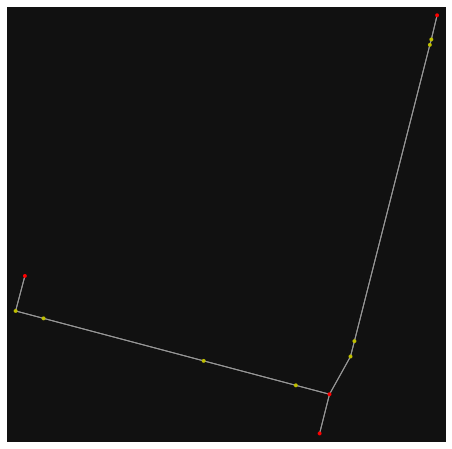

In [24]:
# turn off strict mode and see what nodes we'd remove, in yellow
nc = ["r" if ox.simplification._is_endpoint(highway_G, node) else "y" for node in highway_G.nodes()]
fig, ax = ox.plot_graph(highway_G, node_color=nc)

In [152]:
# 给POI node找到最近的路段，取出该POI node的Amenity类型 或者shop 类型
# 把node id，poi类型，边的node pair 存进一个DF
def find_edge_for_node(road_G,poi_df):
    columns = ["source","target",'amenity', 'name', 'geometry', 'shop', 'takeaway',
       'healthcare', 'parking', 'clothes', 'building']
    output_df = pd.DataFrame(columns=columns)
    for row in poi_df.iterrows():
        node_id, node_detail = row[0], row[1]
        coord = node_detail["geometry"]
        u,v,_ = ox.distance.nearest_edges(road_G, coord.x,coord.y)#,return_dist=True)
        mapping_row = [u,v]
        mapping_row= mapping_row+list(node_detail.to_dict().values())
        output_df = pd.concat([output_df,pd.DataFrame([mapping_row],
                                            columns=columns,
                                            index=[node_id])])
    return output_df

In [153]:
poi_mapping_df = find_edge_for_node(highway_G,poi_node_df)
print(poi_mapping_df.head())

/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = g

               source      target    amenity              name  \
65389942   9419581522    25771522     cinema  Rialto Newmarket   
331410256    25771321  9419581519    toilets               NaN   
666779075  9419581519    25771321  telephone               NaN   
666779076  9419581522  9419581524  telephone               NaN   
666779078  9415475889  9419581524   post_box               NaN   

                                  geometry shop takeaway healthcare parking  \
65389942   POINT (174.7775985 -36.8683617)  NaN      NaN        NaN     NaN   
331410256   POINT (174.7782315 -36.867124)  NaN      NaN        NaN     NaN   
666779075  POINT (174.7777625 -36.8676572)  NaN      NaN        NaN     NaN   
666779076  POINT (174.7778657 -36.8683972)  NaN      NaN        NaN     NaN   
666779078  POINT (174.7782314 -36.8678756)  NaN      NaN        NaN     NaN   

          clothes building  
65389942      NaN      NaN  
331410256     NaN      NaN  
666779075     NaN      NaN  
666779076   

/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = g

In [177]:
#把street转成了node，并且加入了周围POI的type当作feature
def construct_street_nodes(highway_graph,poi_mapping_df):
    columns = ["source","target",'street_name','street_length']
    street_node_output_df = pd.DataFrame(columns=columns)

    for edge in highway_graph.edges(data=True):
        u,v,data = edge
        if data['reversed']:
            continue
        street_id,street_name,street_length = data["osmid"],data["name"],\
                                                       data["length"]
        mapping_row = [u,v,street_name,street_length]
        current_street_node_df = pd.DataFrame([mapping_row],
                                              columns=columns,
                                              index=[street_id])

        matched_source = poi_mapping_df[poi_mapping_df["source"]==u]
        matched_poi_df = matched_source[matched_source["target"]==v]
        # drop unneed columns
        matched_poi_df= matched_poi_df.drop(labels=["source","target","name"],axis=1)

        # Go through poi_df and added up the poi on edge node
        for poi_data in matched_poi_df.iterrows():
            for key,value in poi_data[1].to_dict().items():
                if value is None or str(value)=="nan" or key == "geometry":
                    continue
                if (key+":"+value) not in current_street_node_df.columns:
                    current_street_node_df[key+":"+value] =0
                current_street_node_df[key+":"+value] +=1
        street_node_output_df = pd.concat([street_node_output_df,current_street_node_df])
    return street_node_output_df

In [181]:
street_node_df=construct_street_nodes(highway_G,poi_mapping_df)
print(street_node_df.sort_values("street_name").head())

                source      target     street_name  street_length  \
4309711       25771518  3682002528     Kent Street          6.627   
4309711     2765888017  9419581528     Kent Street         21.887   
4309711     3682002528  2765888017     Kent Street         38.020   
4309711     9419581528    25771522     Kent Street          7.997   
1020849117    25771522  9419581522  Osborne Street          9.914   

            amenity:pub  amenity:restaurant  amenity:fast_food  \
4309711             NaN                 NaN                NaN   
4309711             NaN                 NaN                NaN   
4309711             NaN                 NaN                NaN   
4309711             NaN                 NaN                NaN   
1020849117          NaN                 NaN                NaN   

            amenity:car_wash  shop:clothes  clothes:fashion;women  ...  \
4309711                  NaN           NaN                    NaN  ...   
4309711                  NaN           1

In [120]:
def construct_street_edges():
